In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# os.chdir('drive/MyDrive/Colab Notebooks/DeepFake')

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn
from torchvision import models
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
import glob
from albumentations import Compose
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
class video_dataset(Dataset):
    def __init__(self, video_names, labels, sequence_length = 32,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):

        return len(self.video_names)
    def __getitem__(self, id):
        frames = []
        video_path = self.video_names[id]
        temp_video = video_path.split('/')[-2]
#         if '(1)' in temp_video:
#             temp_video = temp_video.replace("(1)","")
#         if not self.labels.loc[self.labels["URI"] == temp_video].empty:
#             index = self.labels.loc[self.labels["URI"] == temp_video].index.values[0]
#             label = self.labels.iloc[index, 1]
        # Tiếp tục xử lý với giá trị 'value' đã lấy được
#         else:
#             print(temp_video)
#             return
    # if 'origin' in temp_video:
    #   label = 0
    # elif 'Deepfakes' in temp_video:
    #   label = 1
    # elif 'Face2Face' in temp_video:
    #   label = 2
    # elif 'FaceShifter' in temp_video:
    #   label = 3
    # elif 'FaceSwap' in temp_video:
    #   label = 4
    # elif 'NeuralTextures' in temp_video:
    #   label = 5
        if 'fake' in temp_video:
            label = 0
        else:
            label = 1
#         if(label == 'FAKE'):
#             label = 0
#         if(label == 'REAL'):
#             label = 1

        for i,frame in enumerate(self.frame_extract(video_path)):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        #print(len(frames))
        if len(frames) == 0:
            return
        if (len(frames) > 0 and len(frames) < self.count):
            for i in range(self.count - len(frames)):
                frames.append(frames[-1])
        # print(padded_tensors)
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames, label
    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

In [5]:
label_train = pd.read_csv('/kaggle/input/my-dfdc/metadata_dfdc.csv')
label_train

,URI,label,split,original
0,real-sayyjwtjol.mp4,REAL,NaN,NaN
1,fake-qmitaqtqbj.mp4,FAKE,NaN,NaN
2,fake-ockfqfgwmm.mp4,FAKE,NaN,NaN
3,fake-dtymieprub.mp4,FAKE,NaN,NaN
4,fake-eiidlcmtzl.mp4,FAKE,NaN,NaN
...,...,...,...,...
15806,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
15807,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
15808,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
15809,eudeqjhdfd.mp4,REAL,train,NaN


In [6]:
label_test = pd.read_csv('/kaggle/input/my-dfdc/metadata_dfdc.csv')
label_test

,URI,label,split,original
0,real-sayyjwtjol.mp4,REAL,NaN,NaN
1,fake-qmitaqtqbj.mp4,FAKE,NaN,NaN
2,fake-ockfqfgwmm.mp4,FAKE,NaN,NaN
3,fake-dtymieprub.mp4,FAKE,NaN,NaN
4,fake-eiidlcmtzl.mp4,FAKE,NaN,NaN
...,...,...,...,...
15806,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
15807,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
15808,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
15809,eudeqjhdfd.mp4,REAL,train,NaN


In [7]:
label_train['label'].value_counts()

FAKE    13890
REAL     1921
Name: label, dtype: int64

In [8]:
label_test['label'].value_counts()

FAKE    13890
REAL     1921
Name: label, dtype: int64

In [9]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy=0.7)  # Ví dụ tỷ lệ 0.5

# # # Áp dụng SMOTE lên dữ liệu
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur

def create_train_transforms(size=112):
    return Compose([
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        GaussianBlur(blur_limit=3, p=0.05),
        HorizontalFlip(),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ]
    )

In [11]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    np_seed = torch_seed // 2 ** 32 if torch_seed >= 0 else (torch_seed + 1) // 2 ** 32 - 1
    random.seed(torch_seed)
    np.random.seed(np_seed)

In [12]:
import random
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_video_names_fakes = glob.glob('/kaggle/input/my-deepfake-data/my_train_data/fake_videos/*.mp4')
train_video_names_reals = glob.glob('/kaggle/input/my-deepfake-data/my_train_data/real_videos/*.mp4')
train_video_names = train_video_names_fakes + train_video_names_reals
random.shuffle(train_video_names)
print(len(train_video_names))

# test_video_names_fakes = glob.glob('/kaggle/input/deepfake-data-myself/Deepfake_data_all/my_test_data/fake_video/*.mp4')
# test_video_names_reals = glob.glob('/kaggle/input/deepfake-data-myself/Deepfake_data_all/my_test_data/real_video/*.mp4')
# test_video_names = test_video_names_fakes + test_video_names_reals
# random.shuffle(test_video_names)

# print(len(test_video_names))
im_size = 112

train_transforms = transforms.Compose([
            transforms.ToPILImage(),
#             transforms.RandomHorizontalFlip(),  # Đảo ngược ảnh theo chiều ngang
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Tăng cường màu sắc
#             transforms.RandomRotation(degrees=15),  # Xoay ảnh một góc ngẫu nhiên
            transforms.Resize((im_size,im_size)),  # resize ảnh
#             transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#             transforms.RandomRotation(degrees=10, expand=False),
#             transforms.RandomGrayscale(p=0.2),
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.1),
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])# Chuyển ảnh thành tensor
])
train_videos = []
test_videos = []
# train_videos = video_names[:int(0.8*len(video_names))]
# test_videos = video_names[int(0.8*len(video_names)):]
train_videos = train_video_names[:int(0.8*len(train_video_names))]
test_videos = train_video_names[int(0.8*len(train_video_names)):]
# for name in video_names:
#     #print(name)
#     if ('Deepfakes'not in name) and ('Face2Face' not in name) and ('FaceSwap' not in name):
#         train_videos.append(name)
# for name in video_names:
#     if ('Deepfakes' in name) or ('Face2Face' in name) or ('FaceSwap' in name) or ('origin' in name) :
#         test_videos.append(name)


train_data = video_dataset(video_names=train_videos, labels=label_train, sequence_length=10, transform=train_transforms)
val_data = video_dataset(video_names=test_videos, labels=label_test, sequence_length=10, transform=train_transforms)
train_loader = DataLoader(train_data, batch_size = 4,shuffle = True,num_workers = 0, worker_init_fn=worker_init_fn)
valid_loader = DataLoader(val_data, batch_size = 4,shuffle = True,num_workers = 0, worker_init_fn=worker_init_fn)

26452


In [13]:
image, label = train_data[0]

In [14]:
type(label)

int

In [15]:
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

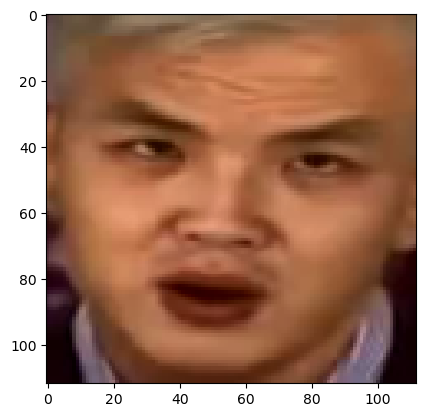

In [16]:
im_plot(image[0])

In [17]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [18]:
import timm
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        #model = models.efficientnet_b7(pretrained = False) #Residual Network CNN
        #model = timm.create_model('xception', pretrained=True)
        #model = models.vgg19(pretrained = True)
        # model = models.wide_resnet50_2(pretrained = False)
        model = models.resnext50_32x4d(pretrained = True)
        #model = timm.create_model('swin_large_patch4_window7_224.ms_in22k', pretrained=False)
        #model = timm.create_model("vit_base_patch16_224", pretrained=False)
        #model = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

        #model = models.resnet50(pretrained = False)
        self.model = nn.Sequential(*list(model.children())[:-2])
        #self.model = model
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x_resized_1 = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x_resized_1)
        #print(x_resized_1.shape)
        x_resized_1 = self.avgpool(fmap)
        #print(x_resized_1.shape)
        # print(batch_size, seq_length)
        x_resized_2 = x_resized_1.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x_resized_2,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))
        #return _, self.linear1(x_resized_2)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
device

'cuda'

In [21]:
model = Model(2).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 163MB/s] 


In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [23]:
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        #if torch.cuda.is_available():
            #print(targets)
        targets = targets.to(device)
        inputs = inputs.to(device)
        #print(targets)
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets)
        acc = calculate_accuracy(outputs, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/kaggle/working/checkpoint.pt')
    return losses.avg,accuracies.avg

In [24]:
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            #if torch.cuda.is_available():
            targets = targets.to(device)
            inputs = inputs.to(device)
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets))
            acc = calculate_accuracy(outputs,targets)
            _,p = torch.max(outputs,1)
            true += (targets).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            print(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        loss,
                        acc
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [25]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [26]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
    loss_train = train_loss_avg
    loss_val = test_loss_avg
    print(num_epochs)
    epochs = range(1,num_epochs+1)
    list_epochs = list(epochs)
    print(list_epochs)
    plt.plot(list_epochs, loss_train, 'g', label='Training loss')
    plt.plot(list_epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
    loss_train = train_accuracy
    loss_val = test_accuracy
    epochs = range(1,num_epochs+1)
    list_epochs = list(epochs)
    print(list_epochs)
    plt.plot(list_epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(list_epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [27]:
import torch
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.0001
#number of epochs
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()

train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)


[Epoch 1/10] [Batch 0 / 5291] [Loss: 0.732344, Acc: 25.00%]
[Epoch 1/10] [Batch 1 / 5291] [Loss: 0.707911, Acc: 50.00%]
[Epoch 1/10] [Batch 2 / 5291] [Loss: 0.683267, Acc: 66.67%]
[Epoch 1/10] [Batch 3 / 5291] [Loss: 0.675467, Acc: 68.75%]
[Epoch 1/10] [Batch 4 / 5291] [Loss: 0.668383, Acc: 70.00%]
[Epoch 1/10] [Batch 5 / 5291] [Loss: 0.672247, Acc: 66.67%]
[Epoch 1/10] [Batch 6 / 5291] [Loss: 0.662816, Acc: 67.86%]
[Epoch 1/10] [Batch 7 / 5291] [Loss: 0.632352, Acc: 71.88%]
[Epoch 1/10] [Batch 8 / 5291] [Loss: 0.642003, Acc: 69.44%]
[Epoch 1/10] [Batch 9 / 5291] [Loss: 0.645666, Acc: 67.50%]
[Epoch 1/10] [Batch 10 / 5291] [Loss: 0.630165, Acc: 70.45%]
[Epoch 1/10] [Batch 11 / 5291] [Loss: 0.616199, Acc: 70.83%]
[Epoch 1/10] [Batch 12 / 5291] [Loss: 0.604239, Acc: 71.15%]
[Epoch 1/10] [Batch 13 / 5291] [Loss: 0.618400, Acc: 69.64%]
[Epoch 1/10] [Batch 14 / 5291] [Loss: 0.627245, Acc: 70.00%]
[Epoch 1/10] [Batch 15 / 5291] [Loss: 0.605800, Acc: 70.31%]
[Epoch 1/10] [Batch 16 / 5291] [Lo

In [ ]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

In [ ]:
os.getcwd()

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/Resnet_mydata.pth')

In [30]:
import glob 
list_name = glob.glob('/kaggle/input/faceforensics-split/FF_test-20231018T110552Z-001/FF_test/*.mp4')

In [31]:
list_label = []
list_name_df = []
for name in list_name:
    if 'origin' in name:
        list_label.append(1)
        list_name_df.append(name.split('/')[-1])
    else:
        list_label.append(0)
        list_name_df.append(name.split('/')[-1])
data = {'URI': list_name_df, 'label': list_label}
FF_test_label = pd.DataFrame(data=data)
FF_test_label

,URI,label
0,NeuralTextures170_186.mp4,0
1,Deepfakes015_919.mp4,0
2,Face2Face142_138.mp4,0
3,Deepfakes308_388.mp4,0
4,Deepfakes714_842.mp4,0
...,...,...
411,FaceSwap420_257.mp4,0
412,FaceShifter917_924.mp4,0
413,origin102.mp4,1
414,NeuralTextures102_114.mp4,0


In [66]:
FF_test_label['label'].value_counts()

0    346
1     70
Name: label, dtype: int64

In [53]:
test_transforms = transforms.Compose([
              # Xoay ảnh một góc ngẫu nhiên
            transforms.Resize((im_size,im_size)),  # resize ảnh
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])# Chuyển ảnh thành tensor
])
val_data_FF = video_dataset(video_names=list_name, labels=FF_test_label, sequence_length=20, transform=test_transforms)
valid_loader_FF = DataLoader(val_data_FF, batch_size = 1,shuffle = True,num_workers = 0, worker_init_fn=worker_init_fn)

In [218]:
import numpy as np

def confident_strategy(pred):
    arr = np.array(pred.to('cpu'))
    #print(arr)
    sorted_indices = np.argsort(arr[:, 1])
    sorted_arr = arr[sorted_indices]
    #print(sorted_arr)
    top_values = sorted_arr[:11]
#     print(top_values)
#     print(top_values[:, 0])
    average_values = np.array([np.mean(top_values[:, 0]), np.mean(top_values[:, 1])])
    print(average_values)
    return torch.tensor(average_values).unsqueeze(0).to('cuda')

def find_max_with_condition(tensor, condition=0.8):
    if tensor[0][0] > condition:
        return (tensor[0][0], torch.tensor([0]).to('cuda'))
    else:
        return (tensor[0][1], torch.tensor([1]).to('cuda'))
    
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    index, pred = find_max_with_condition(outputs)
    #print(pred)
    pred = pred.t()
    print(pred ,targets)
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size       
    
def test_FF(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    num_channels = 30
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            #if torch.cuda.is_available():
            targets = targets.to(device)
            inputs = inputs.to(device)
            outputs_list = []
            for j in range(num_channels):
            # Lấy tensor con từ tensor ban đầu
                channel_tensor = inputs[:, j, :, :, :]
                #print(channel_tensor.unsqueeze(0).shape)
                _,outputs = model(channel_tensor.unsqueeze(0))
                #print(outputs.shape)
                outputs_list.append(outputs)
            #stacked 
            stacked_output = torch.cat(outputs_list, dim=0)
            outputs = confident_strategy(stacked_output)
            #print(outputs)
            #print(outputs.shape)
            loss = torch.mean(criterion(outputs, targets))
            acc = calculate_accuracy(outputs,targets)
            _,p = torch.max(outputs,1)
            true += (targets).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            print(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        loss,
                        acc
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [219]:
criterion = nn.CrossEntropyLoss().cuda()
true,pred,tl,t_acc = test_FF(1,model,valid_loader_FF,criterion)
print(t_acc)

Testing
[ 0.9064152 -0.8705766]
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
[Batch 0 / 416]  [Loss: 0.156274, Acc: 100.00%]
[ 0.9279527  -0.88976365]
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
[Batch 1 / 416]  [Loss: 0.150484, Acc: 100.00%]
[ 0.93781245 -0.9002273 ]
tensor([0], device='cuda:0') tensor([1], device='cuda:0')
[Batch 2 / 416]  [Loss: 1.985709, Acc: 0.00%]
[ 0.73215616 -0.69974697]
tensor([1], device='cuda:0') tensor([0], device='cuda:0')
[Batch 3 / 416]  [Loss: 0.214187, Acc: 0.00%]
[ 0.8761492  -0.84940726]
tensor([0], device='cuda:0') tensor([1], device='cuda:0')
[Batch 4 / 416]  [Loss: 1.889437, Acc: 0.00%]
[ 0.91499513 -0.88062996]
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
[Batch 5 / 416]  [Loss: 0.153599, Acc: 100.00%]
[ 0.89893246 -0.86288494]
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
[Batch 6 / 416]  [Loss: 0.158483, Acc: 100.00%]
[ 0.8572229 -0.8197626]
tensor([0], device='cuda:0') tensor([0], device='cud

In [220]:
print(pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [221]:
print(true)

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

[[331  15]
 [ 65   5]]
True positive =  331
False positive =  15
False negative =  65
True negative =  5




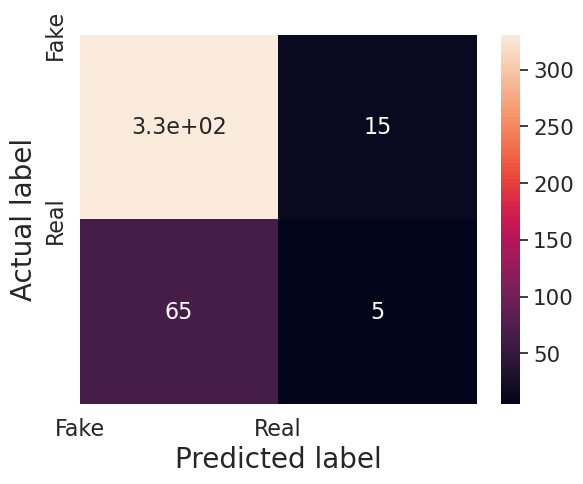

Calculated Accuracy 80.76923076923077


In [222]:
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)